In [3]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
import gc
from tqdm import tqdm

## Case Study: Analyzing the Complexity of New York's Road Network

The goal of this project is to profile the structural complexity of different urban road networks.

The goal is to describe the motifs of road networks with high complexity. Specifically, what makes one road network quantifiably more complex than another?

In order to answer this question, we first have to have some data. And not just any data, but and ultra-clean network-structured dataset that encodes road information. This graph encoding will need to support compression, MDL estimation, and eventually display for my website.

In [4]:
def get_city_center(G):
    # Option A: centroid of node coordinates
    xs = [data["x"] for _, data in G.nodes(data=True)]
    ys = [data["y"] for _, data in G.nodes(data=True)]
    return np.mean(xs), np.mean(ys)

def make_radii(max_km=10, step_km=0.5):
    # radii in meters
    return np.arange(step_km * 1000, max_km * 1000 + 1, step_km * 1000)

def mdl_er_graph(G_sub):
    n = G_sub.number_of_nodes()
    m = G_sub.number_of_edges()
    if n < 2:
        return 0.0

    N_pairs = n * (n - 1) / 2
    if N_pairs == 0:
        return 0.0

    p = m / N_pairs if N_pairs > 0 else 0.0

    # avoid log(0)
    eps = 1e-10
    p = min(max(p, eps), 1 - eps)

    logL = m * math.log(p) + (N_pairs - m) * math.log(1 - p)
    # convert to bits
    return -logL / math.log(2)

def compute_radius_subgraphs(G, center_lon, center_lat, radii_m):
    # Convert nodes to projected CRS so distances are in meters
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
    
    # Project to a local metric CRS
    nodes_proj = nodes_gdf.to_crs(epsg=3857)  # Web Mercator is fine for experiment
    center_point = gpd.GeoSeries([Point(center_lon, center_lat)], crs="EPSG:4326").to_crs(nodes_proj.crs)[0]
    
    # Precompute distances from center (in meters)
    distances = nodes_proj.geometry.distance(center_point)  # pandas Series indexed by node id

    radius_results = []

    for r in radii_m:
        # nodes within radius r
        nodes_in = distances[distances <= r].index
        if len(nodes_in) < 2:
            continue  # nothing interesting to encode yet

        G_r = G.subgraph(nodes_in).copy()
        radius_results.append((r, G_r))

    return radius_results

def mdl_stats(G_sub):
    n = G_sub.number_of_nodes()
    m = G_sub.number_of_edges()
    L = mdl_er_graph(G_sub)
    return {
        "n_nodes": n,
        "n_edges": m,
        "mdl_bits": L,
        "mdl_per_edge": L / m if m > 0 else float("nan"),
        "mdl_per_node": L / n if n > 0 else float("nan"),
    }



In [5]:
# Define place name or coordinates
places = [
    "Manhattan, New York, USA",
    "San Francisco, California, USA",
    "Detroit, Michigan, USA",
    "Chicago, Illinois, USA",
    "Los Angeles, California, USA",
    "Washington, D.C., USA",
    "Seattle, Washington, USA",
    "Miami, Florida, USA",
]

map_data = {}
for place in places:
    # Extract network within bounding box or boundary
    G = ox.graph_from_place(place, network_type='drive')
    map_data[place] = G


### Step 1: Visualize Network Graphs

Generate high-resolution visualizations of each city's road network. This step is separated to manage memory usage - each plot is explicitly cleared after saving to prevent memory accumulation.

In [6]:
# Visualize each city's road network with explicit memory management
print("Generating network visualizations...")
for place in tqdm(map_data, desc="Plotting cities"):
    G = map_data[place]
    
    # Create the plot
    fig, ax = ox.plot_graph(G,
        bgcolor="#111111",
        node_color="#DBBADD",
        node_size=15,
        node_alpha=0.3,
        node_edgecolor="none",
        node_zorder=1,
        edge_color="#69DDFF",
        edge_alpha=0.3,
        show=False,
        close=False
    )
    
    # Save figure at 300 DPI (reduced from 600 for memory efficiency)
    plt.savefig(f"{place}_map.png", dpi=300, bbox_inches='tight')
    
    # Explicit memory cleanup
    plt.close(fig)
    plt.clf()
    gc.collect()
    
print(" Visualization complete")

Generating network visualizations...


Plotting cities: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]

 Visualization complete


<Figure size 640x480 with 0 Axes>

In [ ]:
# Clean and export graph data for each city
cleaned_map_data = {}

print("Cleaning and exporting graph data...")
for place in tqdm(map_data, desc="Processing cities"):
    G = map_data[place]
    
    # Clean the data
    try: 
        G_simplified = ox.simplification.simplify_graph(G)
        G_proj = ox.project_graph(G_simplified)
        G_std = ox.convert.graph_to_gdfs(G_proj, nodes=True, edges=True)
        cleaned_map_data[place] = G_std
    except Exception as e:
        print(f"  Warning: Simplification failed for {place}, using direct projection: {e}")
        G_proj = ox.project_graph(G)
        G_std = ox.convert.graph_to_gdfs(G_proj, nodes=True, edges=True)
        cleaned_map_data[place] = G_std
    
    # Generate canonical representations
    filename = f"{place}"
    nx.write_adjlist(G, str(filename) + ".adjlist")
    
    g6 = nx.to_graph6_bytes(nx.Graph(G), header=False)
    with open(str(filename) + ".g6", "wb") as f:
        f.write(g6)
    
    nx.write_edgelist(G, str(filename) + ".edgelist", data=False)
    
    # Cleanup intermediate objects
    if 'G_simplified' in locals():
        del G_simplified
    del G_proj
    gc.collect()

print(" Cleaning and export complete")

Cleaning and exporting graph data...


Processing cities:   0%|          | 0/8 [00:00<?, ?it/s]

Processing cities:  12%|█▎        | 1/8 [00:05<00:35,  5.08s/it]

Processing cities:  25%|██▌       | 2/8 [00:25<01:25, 14.33s/it]

### Step 2: Clean and Export Graph Data

Simplify graphs, project to metric CRS, and export to multiple file formats (adjlist, graph6, edgelist). Each city is processed sequentially with memory cleanup between operations.

In [ ]:
def plot_mdl_radius(mdl_df, place):
    df = mdl_df[mdl_df["place"] == place].sort_values("radius_m")
    plt.figure()
    plt.plot(df["radius_m"] / 1000, df["mdl_per_edge"], marker="o")
    plt.xlabel("Radius (km)")
    plt.ylabel("MDL per edge (bits)")
    plt.title(f"MDL radius curve – {place}")
    plt.grid(True)
    plt.show()

### Step 3: Radius Analysis and MDL Computation

Compute MDL (Minimum Description Length) statistics for subgraphs at increasing radii from each city center. This measures network complexity at different scales.

In [ ]:
# Perform radius analysis for all cities
print("Computing MDL statistics for radius subgraphs...")
all_radius_rows = []

for place, G in tqdm(map_data.items(), desc="Analyzing cities"):
    center_lon, center_lat = get_city_center(G)
    radii_m = make_radii(max_km=10, step_km=0.5)

    radius_subgraphs = compute_radius_subgraphs(G, center_lon, center_lat, radii_m)

    for r, G_r in radius_subgraphs:
        stats = mdl_stats(G_r)
        stats.update({
            "place": place,
            "radius_m": r,
        })
        all_radius_rows.append(stats)
    
    # Cleanup subgraphs after processing each city
    del radius_subgraphs
    gc.collect()

# Save experiment results
mdl_radius_df = pd.DataFrame(all_radius_rows)
mdl_radius_df.to_csv("mdl_radius_results.csv", index=False)

print(f"    Radius analysis complete: {len(all_radius_rows)} subgraphs analyzed")
print(f"    Results saved to mdl_radius_results.csv")

### Step 4: Visualize MDL Results

Plot the MDL curves showing how network complexity varies with radius for each city.

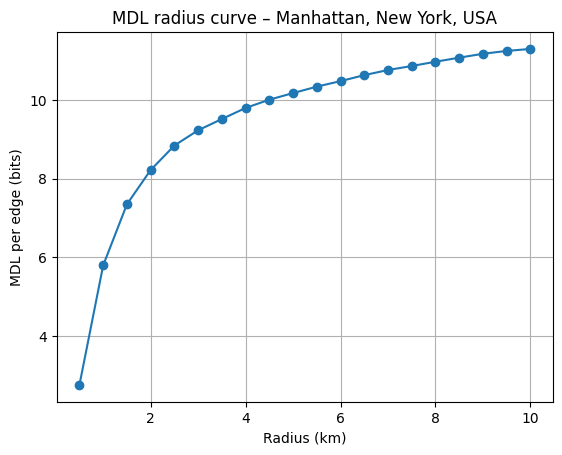

In [ ]:
for place, G in map_data.items():
    plot_mdl_radius(mdl_radius_df, place)